# ResNet-18 Resolution Comparison Study

This notebook compares different image resolutions to find the optimal input size for ResNet-18 on alphanumeric character classification.

**Resolutions to Compare:**
- 24x24 (Current)
- 32x32
- 48x48
- 64x64
- 96x96
- 128x128

**Metrics to Compare:**
- Training time
- Validation accuracy
- Test accuracy
- Model size
- GPU memory usage

## Setup and Configuration

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Dataset paths
BASE_PATH = "/media/ubuntu/NVME/AIML project/AlphaNum2"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
VALIDATION_PATH = os.path.join(BASE_PATH, "validation")
TEST_PATH = os.path.join(BASE_PATH, "test")

# Results directory
RESULTS_PATH = "/media/ubuntu/NVME/AIML project/AlphaNum2/results/ResNet-18/resolution_comparison"
os.makedirs(RESULTS_PATH, exist_ok=True)

print(f"Train path: {TRAIN_PATH}")
print(f"Validation path: {VALIDATION_PATH}")
print(f"Test path: {TEST_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")

# Check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ubuntu/anaconda3/envs/rapids-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Train path: /media/ubuntu/NVME/AIML project/AlphaNum2/train
Validation path: /media/ubuntu/NVME/AIML project/AlphaNum2/validation
Test path: /media/ubuntu/NVME/AIML project/AlphaNum2/test
Results will be saved to: /media/ubuntu/NVME/AIML project/AlphaNum2/results/ResNet-18/resolution_comparison

Using device: cuda:0
GPU: NVIDIA GeForce RTX 3060 Ti
GPU Memory: 7.65 GB


## Define Resolutions to Test

In [2]:
# Resolutions to compare
RESOLUTIONS = [24, 32, 48, 64, 96, 128]

# Training configuration
NUM_EPOCHS = 20  # Reduced for faster comparison
BATCH_SIZE = 128
LEARNING_RATE = 0.0005

print("Resolution Comparison Configuration:")
print("=" * 60)
print(f"Resolutions to test: {RESOLUTIONS}")
print(f"Number of epochs per resolution: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print("=" * 60)

Resolution Comparison Configuration:
Resolutions to test: [24, 32, 48, 64, 96, 128]
Number of epochs per resolution: 20
Batch size: 128
Learning rate: 0.0005


## Helper Functions

In [3]:
def filter_and_map_classes(dataset_path, transform):
    """
    Load dataset and map ASCII folder names to labels
    """
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    classes = dataset.classes
    classes.sort()
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    samples = [(path, class_to_idx[dataset.classes[klass]]) for path, klass in dataset.samples]
    dataset.classes = classes
    dataset.class_to_idx = class_to_idx
    dataset.samples = samples
    dataset.targets = [s[1] for s in samples]
    return dataset

def create_model(num_classes, resolution):
    """
    Create ResNet-18 model adapted for grayscale images
    """
    model = resnet18(weights=None)
    
    # Modify for grayscale input
    if resolution <= 32:
        # For small images, use smaller kernel and no stride
        model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        model.maxpool = nn.Identity()
    else:
        # For larger images, use standard configuration with stride
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Keep maxpool for larger images
    
    # Modify output layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

def train_and_evaluate(model, train_loader, val_loader, test_loader, device, epochs, lr):
    """
    Train and evaluate model, returning metrics
    """
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    
    start_time = time.time()
    best_val_accuracy = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
        
        print(f'  Epoch [{epoch+1:2d}/{epochs}] | '
              f'Train: {epoch_train_acc:.2f}% | Val: {epoch_val_acc:.2f}%')
    
    training_time = time.time() - start_time
    
    # Test evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    
    # Calculate model size
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    model_size_mb = (param_size + buffer_size) / 1024**2
    
    # Get GPU memory usage
    if torch.cuda.is_available():
        gpu_memory_mb = torch.cuda.max_memory_allocated() / 1024**2
    else:
        gpu_memory_mb = 0
    
    return {
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_accuracy': best_val_accuracy,
        'final_train_accuracy': train_accuracies[-1],
        'final_val_accuracy': val_accuracies[-1],
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'model_size_mb': model_size_mb,
        'gpu_memory_mb': gpu_memory_mb
    }

print("Helper functions defined successfully!")

Helper functions defined successfully!


## Run Resolution Comparison Experiment

In [4]:
# Storage for all results
all_results = {}

print("\n" + "=" * 80)
print("STARTING RESOLUTION COMPARISON EXPERIMENT")
print("=" * 80)

# Get number of classes from training data
temp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=temp_transform)
num_classes = len(temp_dataset.classes)
print(f"\nNumber of classes: {num_classes}\n")

for resolution in RESOLUTIONS:
    print("\n" + "=" * 80)
    print(f"TESTING RESOLUTION: {resolution}x{resolution}")
    print("=" * 80)
    
    # Clear GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
    
    # Define transforms for this resolution
    data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load datasets
    print(f"Loading datasets with {resolution}x{resolution} images...")
    train_dataset = filter_and_map_classes(TRAIN_PATH, data_transforms)
    val_dataset = filter_and_map_classes(VALIDATION_PATH, data_transforms)
    test_dataset = filter_and_map_classes(TEST_PATH, data_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Create model
    print(f"\nCreating ResNet-18 model for {resolution}x{resolution} images...")
    model = create_model(num_classes, resolution)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train and evaluate
    print(f"\nStarting training for {NUM_EPOCHS} epochs...\n")
    results = train_and_evaluate(
        model, train_loader, val_loader, test_loader,
        device, NUM_EPOCHS, LEARNING_RATE
    )
    
    # Store results
    all_results[resolution] = results
    
    # Print summary
    print(f"\n{'─' * 80}")
    print(f"RESULTS FOR {resolution}x{resolution}:")
    print(f"{'─' * 80}")
    print(f"  Training Time: {results['training_time']:.2f} seconds ({results['training_time']/60:.2f} minutes)")
    print(f"  Best Validation Accuracy: {results['best_val_accuracy']:.2f}%")
    print(f"  Final Validation Accuracy: {results['final_val_accuracy']:.2f}%")
    print(f"  Test Accuracy: {results['test_accuracy']:.2f}%")
    print(f"  Model Size: {results['model_size_mb']:.2f} MB")
    if results['gpu_memory_mb'] > 0:
        print(f"  Peak GPU Memory: {results['gpu_memory_mb']:.2f} MB")
    print(f"{'─' * 80}")
    
    # Save model
    model_path = os.path.join(RESULTS_PATH, f'resnet18_{resolution}x{resolution}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"  Model saved to: {model_path}")

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED!")
print("=" * 80)


STARTING RESOLUTION COMPARISON EXPERIMENT

Number of classes: 53


TESTING RESOLUTION: 24x24
Loading datasets with 24x24 images...
Train samples: 13250
Validation samples: 7439
Test samples: 11423

Creating ResNet-18 model for 24x24 images...
Total parameters: 11,194,869
Trainable parameters: 11,194,869

Starting training for 20 epochs...

  Epoch [ 1/20] | Train: 63.14% | Val: 77.08%
  Epoch [ 2/20] | Train: 84.82% | Val: 82.42%
  Epoch [ 3/20] | Train: 89.56% | Val: 82.47%
  Epoch [ 4/20] | Train: 92.69% | Val: 82.56%
  Epoch [ 5/20] | Train: 93.99% | Val: 84.34%
  Epoch [ 6/20] | Train: 95.68% | Val: 83.29%
  Epoch [ 7/20] | Train: 96.71% | Val: 83.02%
  Epoch [ 8/20] | Train: 97.28% | Val: 84.10%
  Epoch [ 9/20] | Train: 97.79% | Val: 82.62%
  Epoch [10/20] | Train: 97.69% | Val: 83.82%
  Epoch [11/20] | Train: 98.29% | Val: 84.12%
  Epoch [12/20] | Train: 98.75% | Val: 83.05%
  Epoch [13/20] | Train: 98.96% | Val: 84.42%
  Epoch [14/20] | Train: 99.26% | Val: 85.43%
  Epoch [15/2

## Compare Results Across All Resolutions

In [5]:
# Create comparison dataframe
comparison_data = {
    'Resolution': [],
    'Best Val Accuracy (%)': [],
    'Final Val Accuracy (%)': [],
    'Test Accuracy (%)': [],
    'Training Time (min)': [],
    'Model Size (MB)': [],
    'GPU Memory (MB)': []
}

for resolution in RESOLUTIONS:
    results = all_results[resolution]
    comparison_data['Resolution'].append(f"{resolution}x{resolution}")
    comparison_data['Best Val Accuracy (%)'].append(results['best_val_accuracy'])
    comparison_data['Final Val Accuracy (%)'].append(results['final_val_accuracy'])
    comparison_data['Test Accuracy (%)'].append(results['test_accuracy'])
    comparison_data['Training Time (min)'].append(results['training_time'] / 60)
    comparison_data['Model Size (MB)'].append(results['model_size_mb'])
    comparison_data['GPU Memory (MB)'].append(results['gpu_memory_mb'])

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("RESOLUTION COMPARISON SUMMARY")
print("=" * 80)
print(df_comparison.to_string(index=False))
print("=" * 80)

# Save to CSV
csv_path = os.path.join(RESULTS_PATH, 'resolution_comparison.csv')
df_comparison.to_csv(csv_path, index=False)
print(f"\n✅ Results saved to: {csv_path}")

# Find best resolution
best_test_idx = df_comparison['Test Accuracy (%)'].idxmax()
best_resolution = df_comparison.loc[best_test_idx, 'Resolution']
best_accuracy = df_comparison.loc[best_test_idx, 'Test Accuracy (%)']

print(f"\n🏆 BEST RESOLUTION: {best_resolution}")
print(f"   Test Accuracy: {best_accuracy:.2f}%")
print(f"   Training Time: {df_comparison.loc[best_test_idx, 'Training Time (min)']:.2f} minutes")


RESOLUTION COMPARISON SUMMARY
Resolution  Best Val Accuracy (%)  Final Val Accuracy (%)  Test Accuracy (%)  Training Time (min)  Model Size (MB)  GPU Memory (MB)
     24x24              85.428149               82.941256          82.080014             2.778157        42.741810       504.001953
     32x32              86.180938               85.199624          84.478683             3.566580        42.741810       755.220703
     48x48              86.033069               85.078640          84.364878             2.305405        42.751575       315.250000
     64x64              86.086840               85.750773          85.949400             2.510436        42.751575       403.375000
     96x96              86.301922               85.092082          85.450407             3.176641        42.751575       673.750000
   128x128              86.355693               82.121253          82.543990             4.116456        42.751575      1046.875000

✅ Results saved to: /media/ubuntu/NVME/AIML 

## Visualize Comparison Results

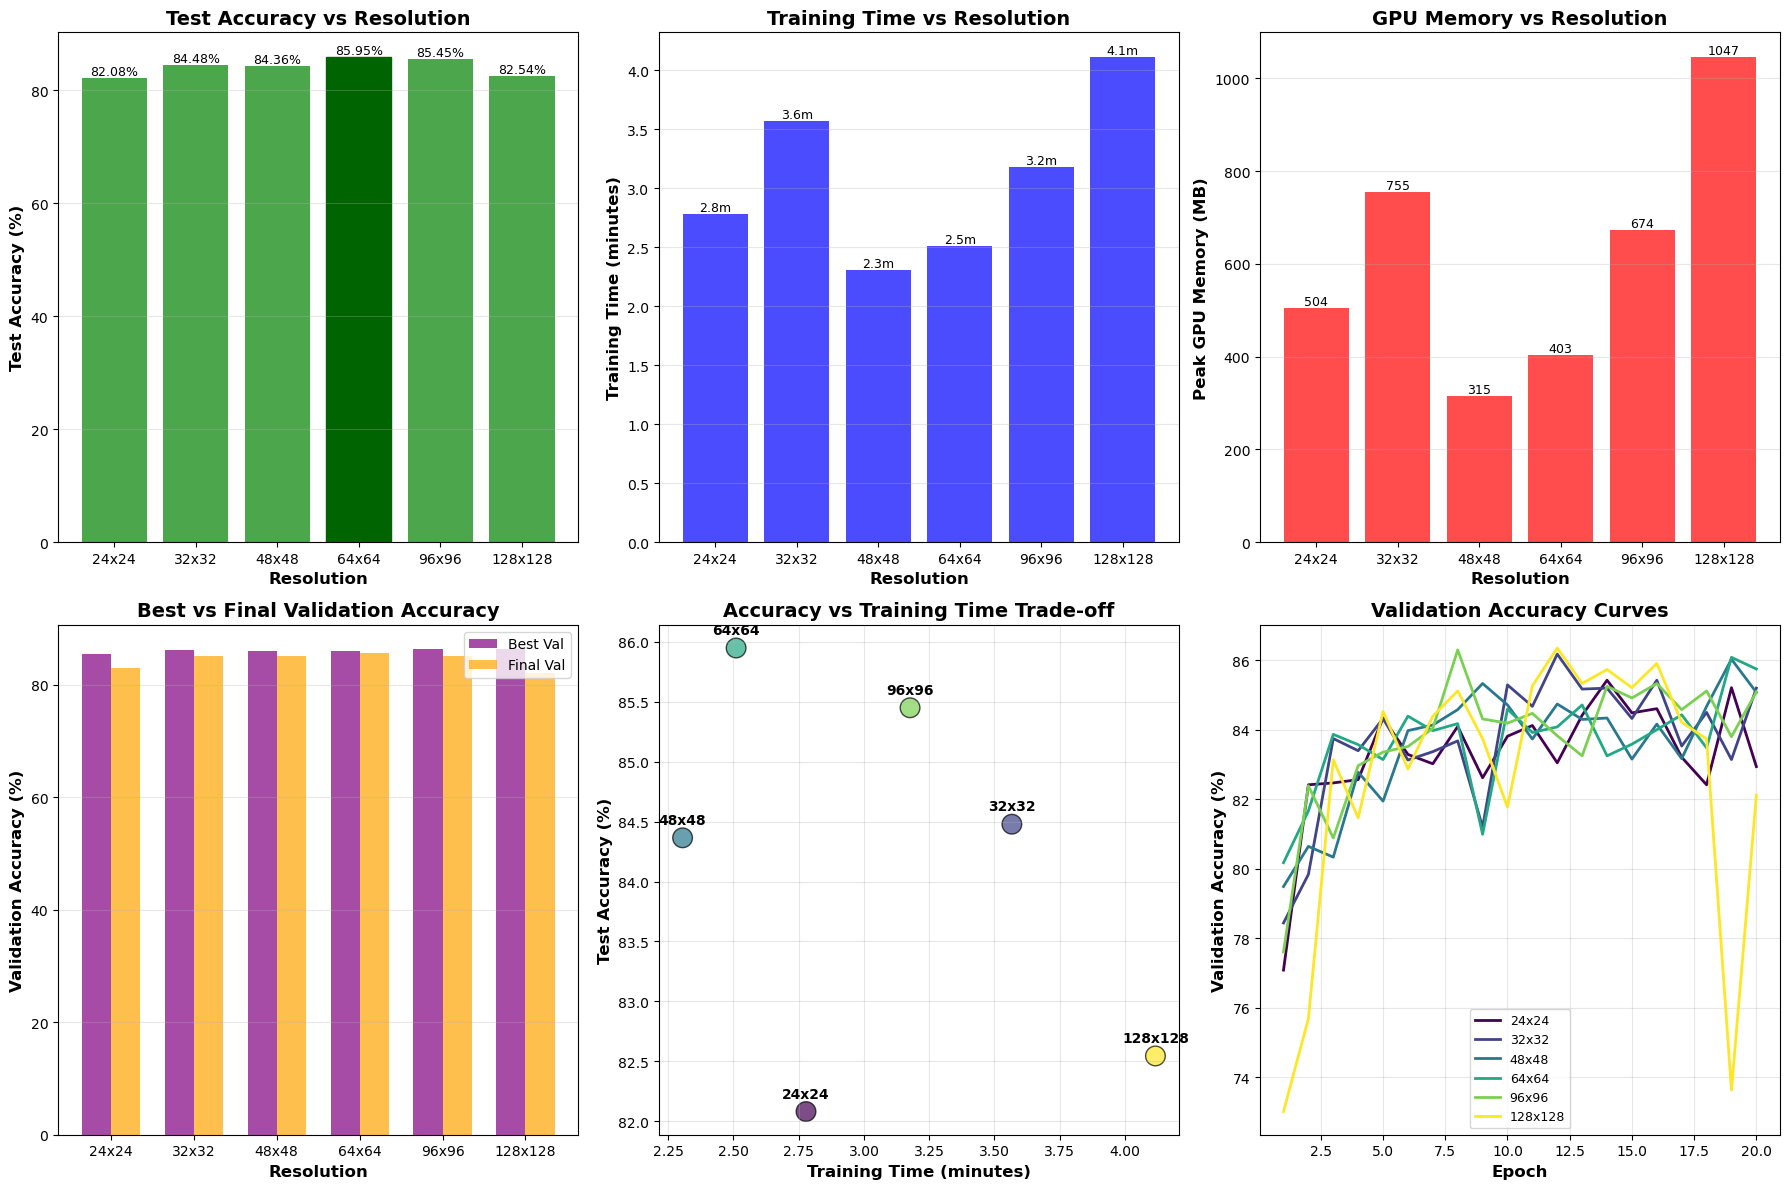


✅ Visualization saved to: /media/ubuntu/NVME/AIML project/AlphaNum2/results/ResNet-18/resolution_comparison/resolution_comparison.png


In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

resolutions_str = [f"{r}x{r}" for r in RESOLUTIONS]

# Plot 1: Test Accuracy
ax1 = axes[0, 0]
bars1 = ax1.bar(resolutions_str, df_comparison['Test Accuracy (%)'], color='green', alpha=0.7)
ax1.set_xlabel('Resolution', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy vs Resolution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
# Highlight best
bars1[best_test_idx].set_color('darkgreen')
bars1[best_test_idx].set_alpha(1.0)
# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Training Time
ax2 = axes[0, 1]
bars2 = ax2.bar(resolutions_str, df_comparison['Training Time (min)'], color='blue', alpha=0.7)
ax2.set_xlabel('Resolution', fontsize=12, fontweight='bold')
ax2.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Training Time vs Resolution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}m', ha='center', va='bottom', fontsize=9)

# Plot 3: GPU Memory Usage
ax3 = axes[0, 2]
if df_comparison['GPU Memory (MB)'].sum() > 0:
    bars3 = ax3.bar(resolutions_str, df_comparison['GPU Memory (MB)'], color='red', alpha=0.7)
    ax3.set_xlabel('Resolution', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Peak GPU Memory (MB)', fontsize=12, fontweight='bold')
    ax3.set_title('GPU Memory vs Resolution', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.0f}', ha='center', va='bottom', fontsize=9)
else:
    ax3.text(0.5, 0.5, 'GPU Memory\nData Not Available', 
             ha='center', va='center', fontsize=14, transform=ax3.transAxes)
    ax3.set_xticks([])
    ax3.set_yticks([])

# Plot 4: Validation Accuracy (Best vs Final)
ax4 = axes[1, 0]
x = np.arange(len(resolutions_str))
width = 0.35
bars4a = ax4.bar(x - width/2, df_comparison['Best Val Accuracy (%)'], width, 
                 label='Best Val', color='purple', alpha=0.7)
bars4b = ax4.bar(x + width/2, df_comparison['Final Val Accuracy (%)'], width,
                 label='Final Val', color='orange', alpha=0.7)
ax4.set_xlabel('Resolution', fontsize=12, fontweight='bold')
ax4.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Best vs Final Validation Accuracy', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(resolutions_str)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Accuracy vs Training Time Trade-off
ax5 = axes[1, 1]
scatter = ax5.scatter(df_comparison['Training Time (min)'], 
                     df_comparison['Test Accuracy (%)'],
                     s=200, c=range(len(RESOLUTIONS)), cmap='viridis', alpha=0.7, edgecolors='black')
for i, res in enumerate(resolutions_str):
    ax5.annotate(res, 
                (df_comparison['Training Time (min)'][i], df_comparison['Test Accuracy (%)'][i]),
                textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
ax5.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax5.set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Training Curves for All Resolutions
ax6 = axes[1, 2]
colors_curves = plt.cm.viridis(np.linspace(0, 1, len(RESOLUTIONS)))
for i, resolution in enumerate(RESOLUTIONS):
    results = all_results[resolution]
    epochs = range(1, len(results['val_accuracies']) + 1)
    ax6.plot(epochs, results['val_accuracies'], 
            label=f"{resolution}x{resolution}", color=colors_curves[i], linewidth=2)
ax6.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax6.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax6.set_title('Validation Accuracy Curves', fontsize=14, fontweight='bold')
ax6.legend(loc='best', fontsize=9)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'resolution_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to:", os.path.join(RESULTS_PATH, 'resolution_comparison.png'))

## Detailed Training Curves for Each Resolution

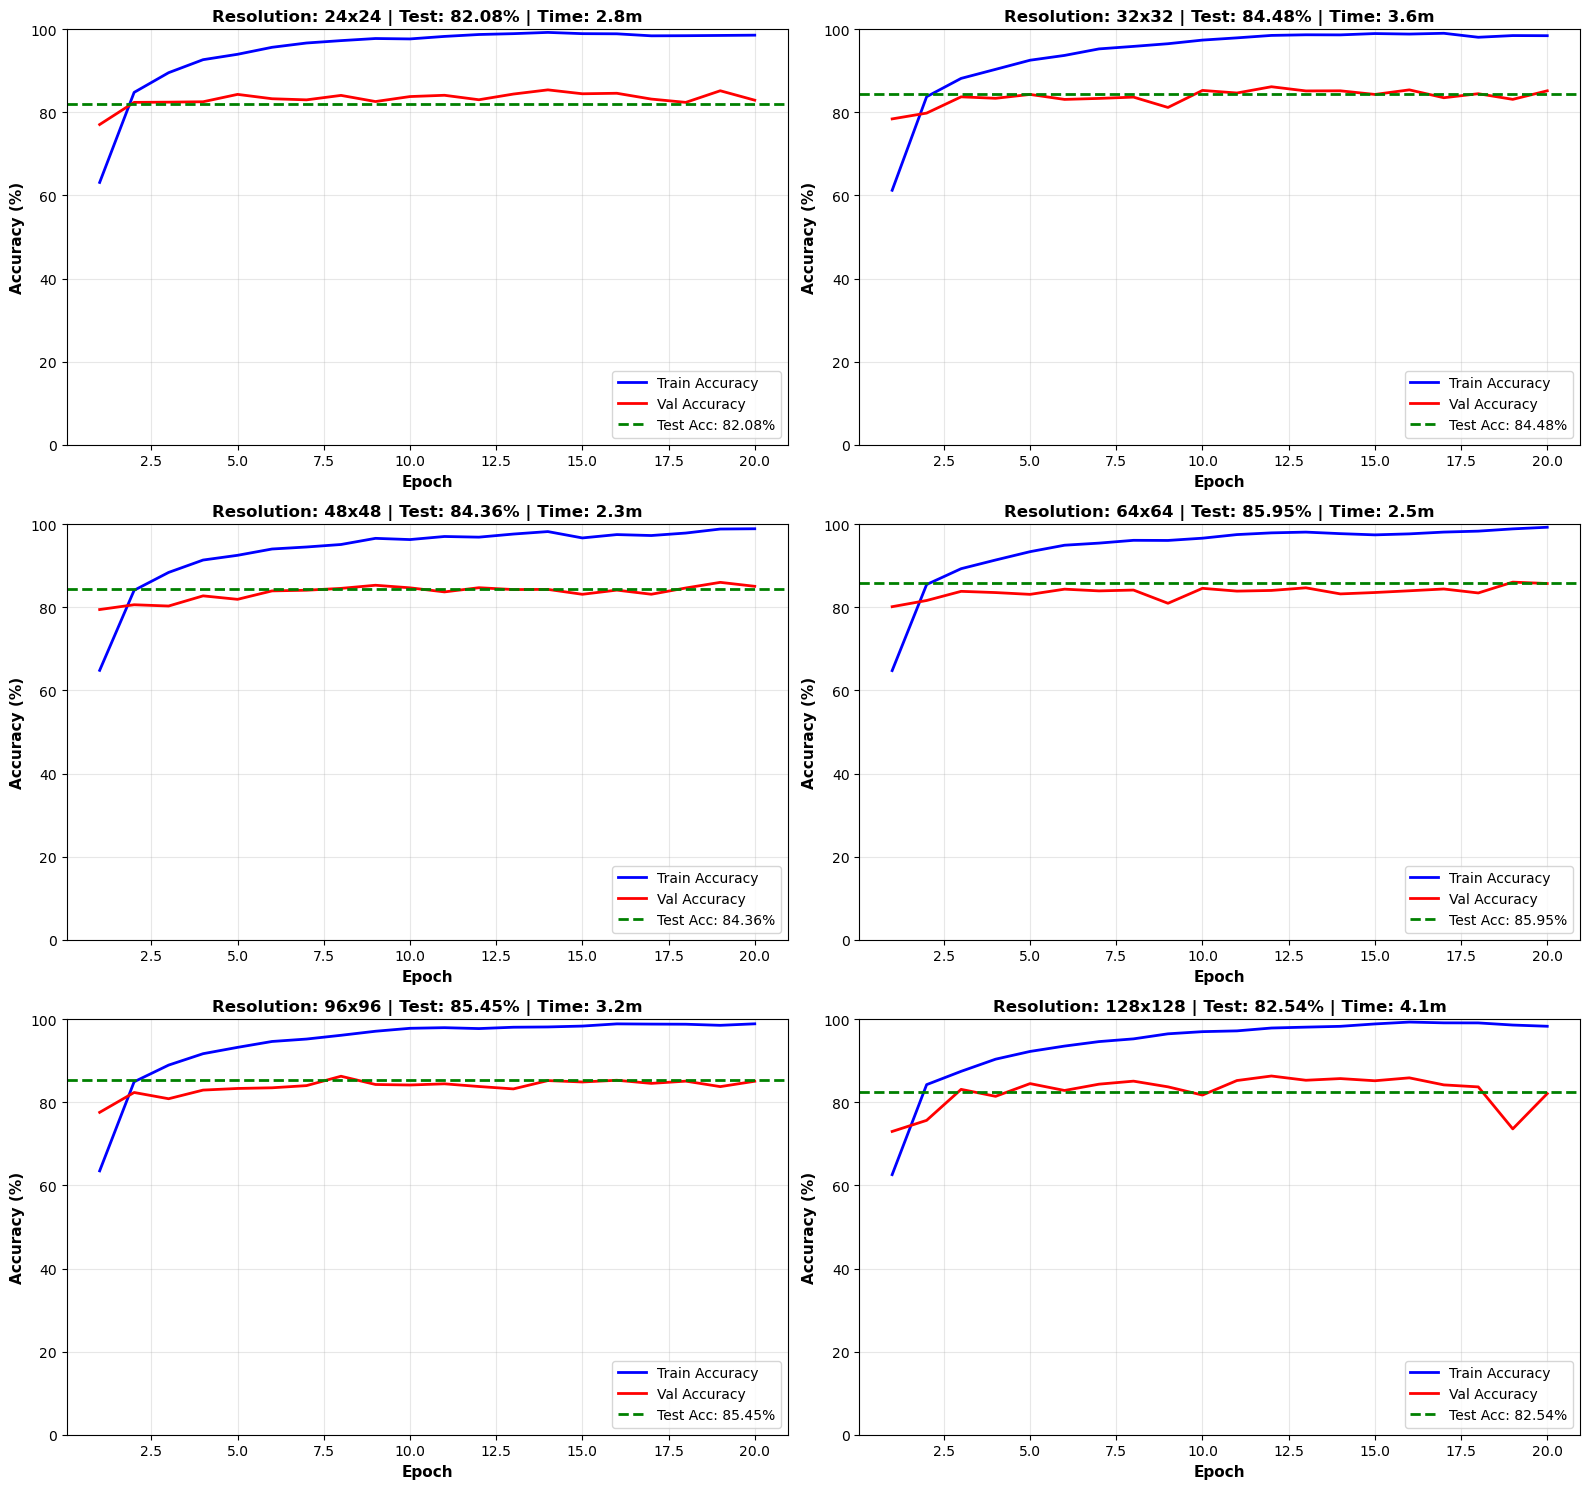

✅ Individual training curves saved!


In [7]:
# Create individual plots for each resolution
rows = (len(RESOLUTIONS) + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 5 * rows))
axes = axes.flatten()

for i, resolution in enumerate(RESOLUTIONS):
    ax = axes[i]
    results = all_results[resolution]
    epochs = range(1, len(results['train_accuracies']) + 1)
    
    # Plot training and validation accuracies
    ax.plot(epochs, results['train_accuracies'], 'b-', label='Train Accuracy', linewidth=2)
    ax.plot(epochs, results['val_accuracies'], 'r-', label='Val Accuracy', linewidth=2)
    
    # Add horizontal line for test accuracy
    ax.axhline(y=results['test_accuracy'], color='g', linestyle='--', 
               linewidth=2, label=f"Test Acc: {results['test_accuracy']:.2f}%")
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Resolution: {resolution}x{resolution} | Test: {results["test_accuracy"]:.2f}% | Time: {results["training_time"]/60:.1f}m',
                fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 100])

# Hide extra subplots if odd number of resolutions
if len(RESOLUTIONS) % 2 != 0:
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'individual_training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Individual training curves saved!")

## Final Recommendations

In [8]:
print("\n" + "=" * 80)
print("FINAL RECOMMENDATIONS")
print("=" * 80)

# Find optimal resolution based on different criteria
best_accuracy_idx = df_comparison['Test Accuracy (%)'].idxmax()
fastest_training_idx = df_comparison['Training Time (min)'].idxmin()

# Calculate efficiency score (accuracy / training_time)
df_comparison['Efficiency Score'] = df_comparison['Test Accuracy (%)'] / df_comparison['Training Time (min)']
best_efficiency_idx = df_comparison['Efficiency Score'].idxmax()

print(f"\n🏆 BEST ACCURACY:")
print(f"   Resolution: {df_comparison.loc[best_accuracy_idx, 'Resolution']}")
print(f"   Test Accuracy: {df_comparison.loc[best_accuracy_idx, 'Test Accuracy (%)']:.2f}%")
print(f"   Training Time: {df_comparison.loc[best_accuracy_idx, 'Training Time (min)']:.2f} minutes")

print(f"\n⚡ FASTEST TRAINING:")
print(f"   Resolution: {df_comparison.loc[fastest_training_idx, 'Resolution']}")
print(f"   Test Accuracy: {df_comparison.loc[fastest_training_idx, 'Test Accuracy (%)']:.2f}%")
print(f"   Training Time: {df_comparison.loc[fastest_training_idx, 'Training Time (min)']:.2f} minutes")

print(f"\n⚖️  BEST EFFICIENCY (Accuracy/Time):")
print(f"   Resolution: {df_comparison.loc[best_efficiency_idx, 'Resolution']}")
print(f"   Test Accuracy: {df_comparison.loc[best_efficiency_idx, 'Test Accuracy (%)']:.2f}%")
print(f"   Training Time: {df_comparison.loc[best_efficiency_idx, 'Training Time (min)']:.2f} minutes")
print(f"   Efficiency Score: {df_comparison.loc[best_efficiency_idx, 'Efficiency Score']:.2f}")

# Analysis
print(f"\n📊 ANALYSIS:")
accuracy_improvement = df_comparison.loc[best_accuracy_idx, 'Test Accuracy (%)'] - df_comparison.loc[0, 'Test Accuracy (%)']
time_increase = df_comparison.loc[best_accuracy_idx, 'Training Time (min)'] - df_comparison.loc[0, 'Training Time (min)']

print(f"   • Best resolution improved accuracy by {accuracy_improvement:.2f}% over 24x24")
print(f"   • But increased training time by {time_increase:.2f} minutes")

if best_efficiency_idx == best_accuracy_idx:
    print(f"   • The best accuracy resolution is also the most efficient!")
else:
    print(f"   • For balanced performance, consider {df_comparison.loc[best_efficiency_idx, 'Resolution']}")

print(f"\n💡 RECOMMENDATION:")
if accuracy_improvement > 5:
    print(f"   ✅ Use {df_comparison.loc[best_accuracy_idx, 'Resolution']} for BEST ACCURACY")
    print(f"      Significant accuracy improvement justifies the extra training time.")
elif accuracy_improvement > 2:
    print(f"   ✅ Use {df_comparison.loc[best_efficiency_idx, 'Resolution']} for BALANCED PERFORMANCE")
    print(f"      Good accuracy with reasonable training time.")
else:
    print(f"   ✅ Stick with 24x24 for FAST TRAINING")
    print(f"      Minimal accuracy difference with fastest training.")

print("\n" + "=" * 80)


FINAL RECOMMENDATIONS

🏆 BEST ACCURACY:
   Resolution: 64x64
   Test Accuracy: 85.95%
   Training Time: 2.51 minutes

⚡ FASTEST TRAINING:
   Resolution: 48x48
   Test Accuracy: 84.36%
   Training Time: 2.31 minutes

⚖️  BEST EFFICIENCY (Accuracy/Time):
   Resolution: 48x48
   Test Accuracy: 84.36%
   Training Time: 2.31 minutes
   Efficiency Score: 36.59

📊 ANALYSIS:
   • Best resolution improved accuracy by 3.87% over 24x24
   • But increased training time by -0.27 minutes
   • For balanced performance, consider 48x48

💡 RECOMMENDATION:
   ✅ Use 48x48 for BALANCED PERFORMANCE
      Good accuracy with reasonable training time.



## Export Results Summary

In [9]:
# Create a comprehensive report
report = f"""
{'=' * 80}
RESNET-18 RESOLUTION COMPARISON STUDY
{'=' * 80}

Experiment Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Device: {device}
Dataset: AlphaNum2
Number of Classes: {num_classes}
Training Epochs: {NUM_EPOCHS}
Batch Size: {BATCH_SIZE}
Learning Rate: {LEARNING_RATE}

{'=' * 80}
RESULTS SUMMARY
{'=' * 80}

{df_comparison.to_string(index=False)}

{'=' * 80}
TOP PERFORMERS
{'=' * 80}

Best Accuracy: {df_comparison.loc[best_accuracy_idx, 'Resolution']}
  - Test Accuracy: {df_comparison.loc[best_accuracy_idx, 'Test Accuracy (%)']:.2f}%
  - Training Time: {df_comparison.loc[best_accuracy_idx, 'Training Time (min)']:.2f} minutes

Fastest Training: {df_comparison.loc[fastest_training_idx, 'Resolution']}
  - Test Accuracy: {df_comparison.loc[fastest_training_idx, 'Test Accuracy (%)']:.2f}%
  - Training Time: {df_comparison.loc[fastest_training_idx, 'Training Time (min)']:.2f} minutes

Best Efficiency: {df_comparison.loc[best_efficiency_idx, 'Resolution']}
  - Test Accuracy: {df_comparison.loc[best_efficiency_idx, 'Test Accuracy (%)']:.2f}%
  - Training Time: {df_comparison.loc[best_efficiency_idx, 'Training Time (min)']:.2f} minutes
  - Efficiency Score: {df_comparison.loc[best_efficiency_idx, 'Efficiency Score']:.2f}

{'=' * 80}
"""

# Save report
report_path = os.path.join(RESULTS_PATH, 'comparison_report.txt')
with open(report_path, 'w') as f:
    f.write(report)

print(report)
print(f"\n✅ Full report saved to: {report_path}")
print(f"\n📁 All results saved in: {RESULTS_PATH}")
print(f"   - resolution_comparison.csv")
print(f"   - resolution_comparison.png")
print(f"   - individual_training_curves.png")
print(f"   - comparison_report.txt")
print(f"   - resnet18_[resolution].pth (model files)")


RESNET-18 RESOLUTION COMPARISON STUDY

Experiment Date: 2025-10-19 16:53:13
Device: cuda:0
Dataset: AlphaNum2
Number of Classes: 53
Training Epochs: 20
Batch Size: 128
Learning Rate: 0.0005

RESULTS SUMMARY

Resolution  Best Val Accuracy (%)  Final Val Accuracy (%)  Test Accuracy (%)  Training Time (min)  Model Size (MB)  GPU Memory (MB)  Efficiency Score
     24x24              85.428149               82.941256          82.080014             2.778157        42.741810       504.001953         29.544767
     32x32              86.180938               85.199624          84.478683             3.566580        42.741810       755.220703         23.686185
     48x48              86.033069               85.078640          84.364878             2.305405        42.751575       315.250000         36.594383
     64x64              86.086840               85.750773          85.949400             2.510436        42.751575       403.375000         34.236842
     96x96              86.301922        